# _____________ ANÁLISIS PARA 15-03-2023 __________

In [2]:
# -*- coding: utf-8 -*-
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Potencia generada por el inversor 

(288, 26)
(142, 3)


/var/folders/pz/w3bcsy5x2wgb_7c0fs6qmkp80000gn/T/ipykernel_96399/2104644733.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_SFV['E'] = df_SFV['Producción fotovoltaica'] / (5/60)


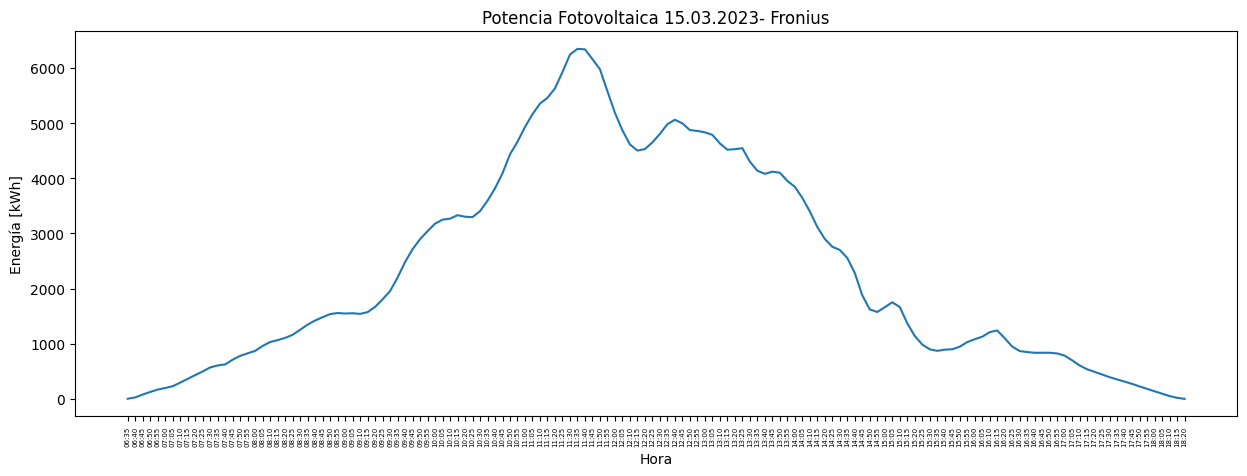

Producción fotovoltaica [kWh/día] = 27.775229999999997
Horas de brillo solar = 1.7145203703703698


In [3]:
# leer el archivo csv inversor 
df_fronius = pd.read_csv('../../Data/Processed/SFV_15-03-2023.csv')
print(df_fronius.shape)

# nuevo dataframe con las columnas de hora y producción fotovoltaica
df_SFV = df_fronius[['Hora', 'Producción fotovoltaica']]
df_SFV['E'] = df_SFV['Producción fotovoltaica'] / (5/60)

# valores de 'Potencia' diferentes de cero
df_SFV = df_SFV[df_SFV['E'] != 0]
print(df_SFV.shape)
# graficar la potencia fotovoltaica
plt.figure(figsize=(15, 5))
plt.plot(df_SFV['Hora'], df_SFV['E'])
plt.title('Potencia Fotovoltaica 15.03.2023- Fronius')
plt.xlabel('Hora')
plt.ylabel('Energía [kWh]')
plt.xticks(rotation=90, size=5)
plt.show()
#sumar todos los valores de energía
energia_total = df_SFV['Producción fotovoltaica'].sum()
print("Producción fotovoltaica [kWh/día] =",energia_total/1000)
hbs = energia_total / (30*0.54)
print("Horas de brillo solar =", hbs/1000)



## Importar DB Solcast

In [4]:
# Leer el archivo csv
df_solcast = pd.read_csv('../../Data/Processed/solcast_15-03-2023_PT5M.csv', sep=',')
# Eliminar el primer carácter de 'Time'
df_solcast['Time'] = df_solcast['Time'].str.slice(1)

print(df_solcast.shape)
df_solcast.head()

(287, 12)


,air_temp,albedo,clearsky_ghi,clearsky_gti,cloud_opacity,dewpoint_temp,GHI,gti,period_end,period,Date,Time
0,11,0.14,0,0,79.5,10.3,0,0,2023-01-01T00:05:00Z,PT5M,2023-01-01,19:05
1,11,0.14,0,0,79.5,10.2,0,0,2023-01-01T00:10:00Z,PT5M,2023-01-01,19:10
2,11,0.14,0,0,79.5,10.2,0,0,2023-01-01T00:15:00Z,PT5M,2023-01-01,19:15
3,11,0.14,0,0,79.5,10.2,0,0,2023-01-01T00:20:00Z,PT5M,2023-01-01,19:20
4,11,0.14,0,0,79.5,10.2,0,0,2023-01-01T00:25:00Z,PT5M,2023-01-01,19:25


## Time matching between DB

In [5]:
# hacer math a la columna de 'Time' de df_solcast y la columna 'Hora' de df_SFV y crear un nuevo dataframe
df_solcast['Time'] = pd.to_datetime(df_solcast['Time'])
df_SFV['Hora'] = pd.to_datetime(df_SFV['Hora'])
df = pd.merge(df_solcast, df_SFV, left_on='Time', right_on='Hora')

print(df.shape)
# eliminar las columnas 'albedo' , 'period_end', 'Hora' y 'period'
df = df.drop(['albedo', 'period_end', 'Hora', 'period'], axis=1)
# en la columna 'Time' solo mostrar la hora
df['Time'] = df['Time'].dt.time
#quitarle los segundos al tiempo
df['Time'] = df['Time'].apply(lambda x: x.strftime('%H:%M'))
df.head()

(142, 15)


/var/folders/pz/w3bcsy5x2wgb_7c0fs6qmkp80000gn/T/ipykernel_96399/3806094400.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_solcast['Time'] = pd.to_datetime(df_solcast['Time'])
/var/folders/pz/w3bcsy5x2wgb_7c0fs6qmkp80000gn/T/ipykernel_96399/3806094400.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_SFV['Hora'] = pd.to_datetime(df_SFV['Hora'])


,air_temp,clearsky_ghi,clearsky_gti,cloud_opacity,dewpoint_temp,GHI,gti,Date,Time,Producción fotovoltaica,E
0,10,42,65,18.4,9.7,35,33,2023-01-01,06:35,0.25,3.00
1,10,57,93,26.2,9.7,42,40,2023-01-01,06:40,2.27,27.24
2,11,72,116,23.1,9.7,56,54,2023-01-01,06:45,6.63,79.56
3,11,89,139,22.8,9.7,69,66,2023-01-01,06:50,10.52,126.24
4,11,107,163,18.2,9.7,87,96,2023-01-01,06:55,14.13,169.56


## Análisis de las variables 

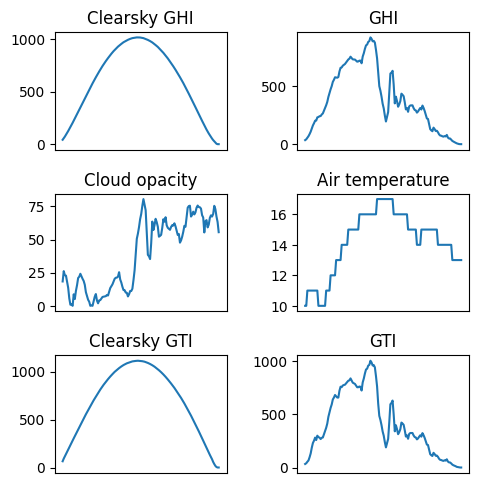

In [6]:
# multiplos graficos de todas las columnas de row_day
fig, ax = plt.subplots(3, 2, figsize=(5, 5))  # 3 filas, 2 columnas
# cuadricula de subplots
plt.tight_layout()

# ajustar espacio entre subplots
# ax[0, 0] clearsky_ghi
ax[0, 0].plot(df['Time'], df['clearsky_ghi'])
ax[0, 0].set_title('Clearsky GHI')
ax[0, 0].get_xaxis().set_visible(False)
# ax[0, 1] GHI
ax[0, 1].plot(df['Time'], df['GHI'])
ax[0, 1].set_title('GHI')
ax[0, 1].get_xaxis().set_visible(False)
# ax[1, 0] cloud_opacity
ax[1, 0].plot(df['Time'], df['cloud_opacity'])
ax[1, 0].set_title('Cloud opacity')
ax[1, 0].get_xaxis().set_visible(False)
# ax[1, 1] air_temp
ax[1, 1].plot(df['Time'], df['air_temp'])
ax[1, 1].set_title('Air temperature')
ax[1, 1].get_xaxis().set_visible(False)
# ax[2, 0] clearsky_gti
ax[2, 0].plot(df['Time'], df['clearsky_gti'])
ax[2, 0].set_title('Clearsky GTI')
ax[2, 0].get_xaxis().set_visible(False)
# ax[2, 1] gti 
ax[2, 1].plot(df['Time'], df['gti'])
ax[2, 1].set_title('GTI')
ax[2, 1].get_xaxis().set_visible(False)

plt.show()




## Potencia calculada a partir de solcast (GHI)

In [7]:
efficiency = 0.2094  # Eficiencia del panel solar
catidad_pv= 30
area =2.274*1.134

df['P'] = df['GHI'] * efficiency *  area * catidad_pv 

## Potencia calculada a partir de fronius 


In [8]:
df['Potencia'] = df['Producción fotovoltaica'] / (5/60)

## Energía a partir de la potencia calculada

Energía calculada solacast [kWh] = 73.73874632959802
Energía calculada fronius [kWh] = 27.775229999999997
Error porcentual: 165.48383696407922 %


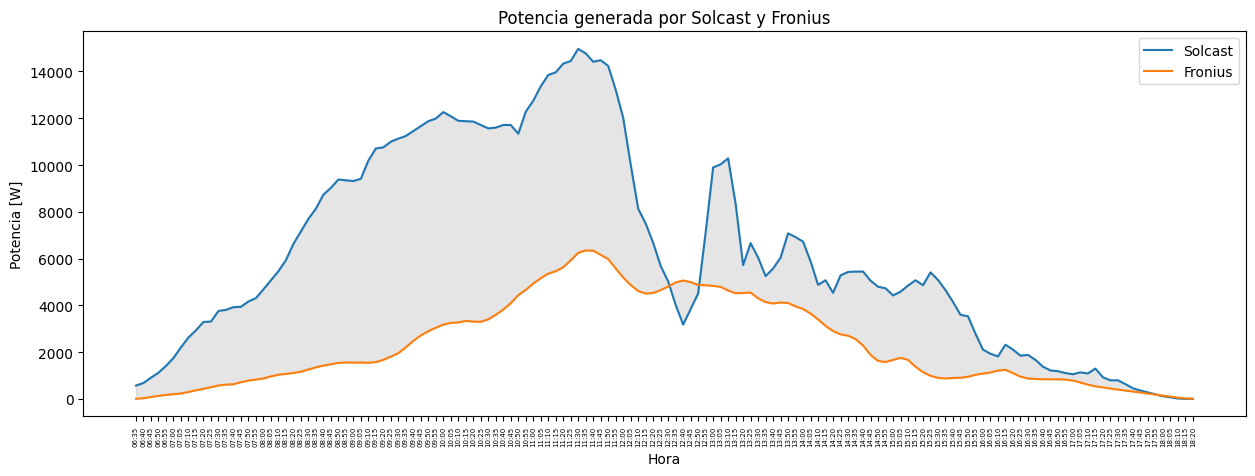

In [9]:
# suma de la potencia generada solcast
energia = df['P']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Potencia y Energía calculada a partir de solcast (clearsky_ghi)

In [10]:
df['P_clearsky'] = df['clearsky_ghi'] * efficiency *  area * catidad_pv 

Energía calculada solacast [kWh] = 117.95121508892399
Energía calculada fronius [kWh] = 27.775229999999997
Error porcentual: 324.6633244402441 %


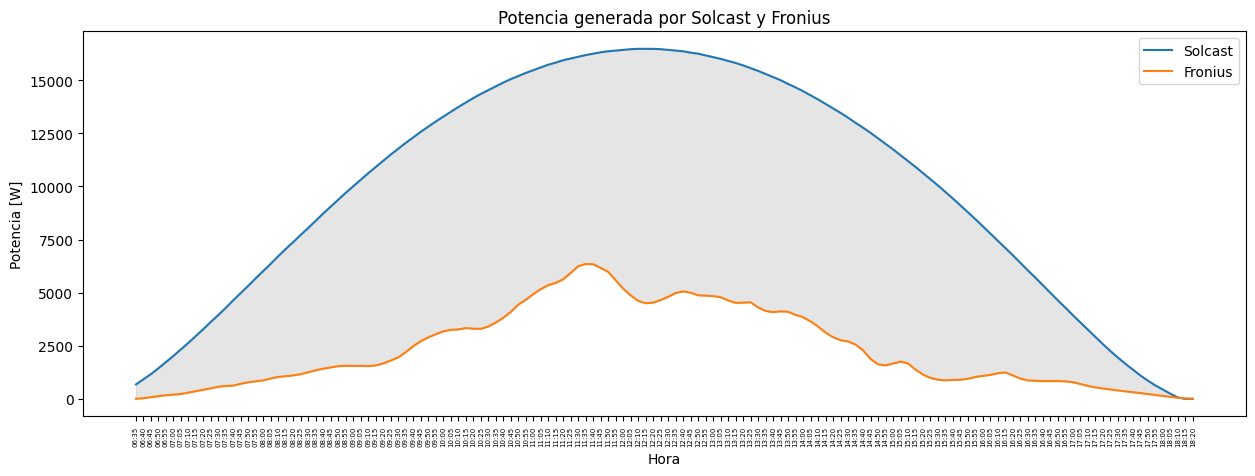

In [11]:
# suma de la potencia generada solcast
energia = df['P_clearsky']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_clearsky'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_clearsky'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Potencia y Energía calculada a partir de solcast (clearsky_gti)

In [12]:
df['P_clearsky'] = df['clearsky_gti'] * efficiency *  area * catidad_pv 

Energía calculada solacast [kWh] = 135.11862876216603
Energía calculada fronius [kWh] = 27.775229999999997
Error porcentual: 386.4716827265374 %


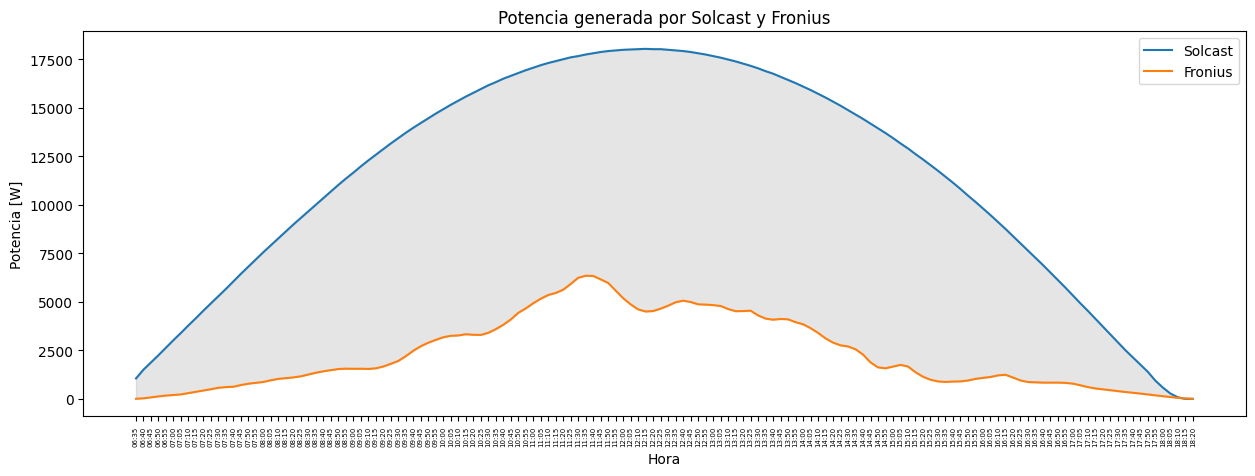

In [13]:
# suma de la potencia generada solcast
energia = df['P_clearsky']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_clearsky'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_clearsky'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Potencia y Energía calculada a partir de solcast (gti)

In [14]:
df['P_gti'] = df['gti'] * efficiency *  area * catidad_pv 

Energía calculada solacast [kWh] = 78.08831044496999
Energía calculada fronius [kWh] = 27.775229999999997
Error porcentual: 181.14370410243228 %


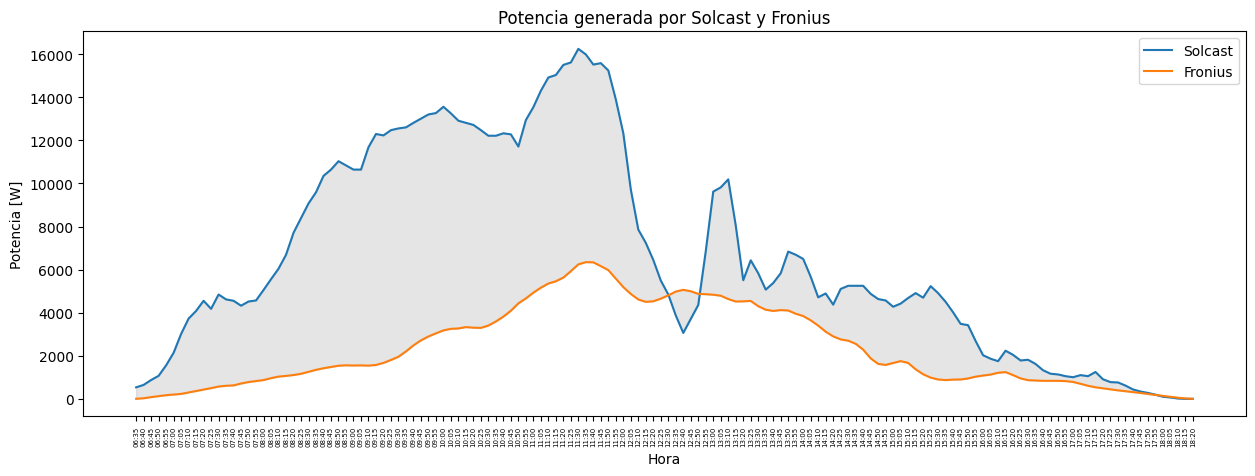

In [15]:
# suma de la potencia generada solcast
energia = df['P_gti']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_gti'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_gti'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Análisis modelo matemático

## Nubosidad

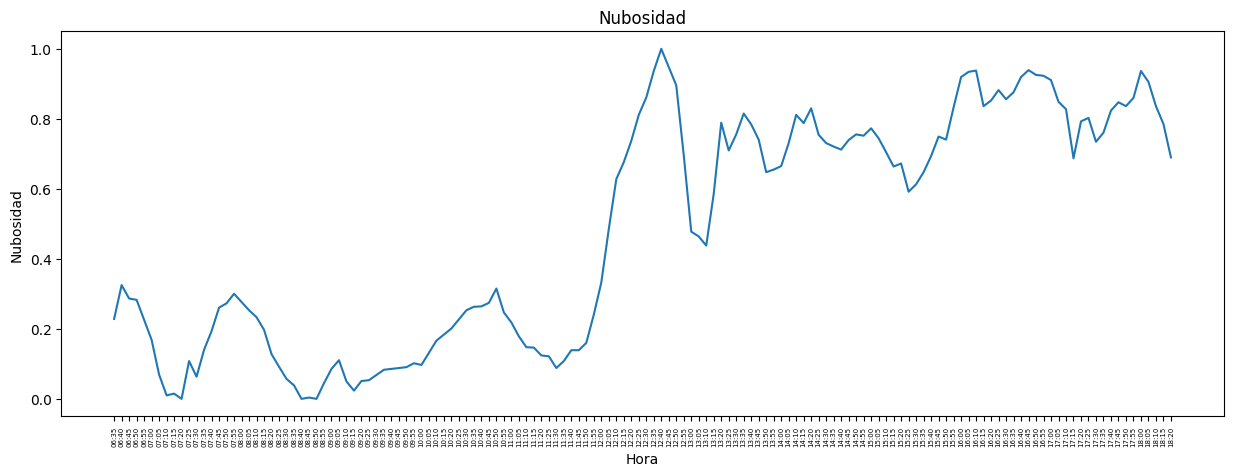

In [16]:
# normalizar 'cloud_opacity' de 0 a 1  en donde 1 es el valor más alto
df['cloud_opacity'] = df['cloud_opacity'] / df['cloud_opacity'].max()

# graficar la nubosidad
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['cloud_opacity'])
plt.title('Nubosidad')
plt.xlabel('Hora')
plt.ylabel('Nubosidad')
plt.xticks(rotation=90, size=5)
plt.show()


## Potencia calulada teniendo en cuenta gti y la nubosidad 

In [17]:
df['P_cloud_opacity'] = df['gti'] * efficiency *  area * catidad_pv * (1 - 0.5*df['cloud_opacity'])

Energía calculada solacast [kWh] = 65.7024557658482
Energía calculada fronius [kWh] = 27.775229999999997
Error porcentual: 136.55053717232298 %


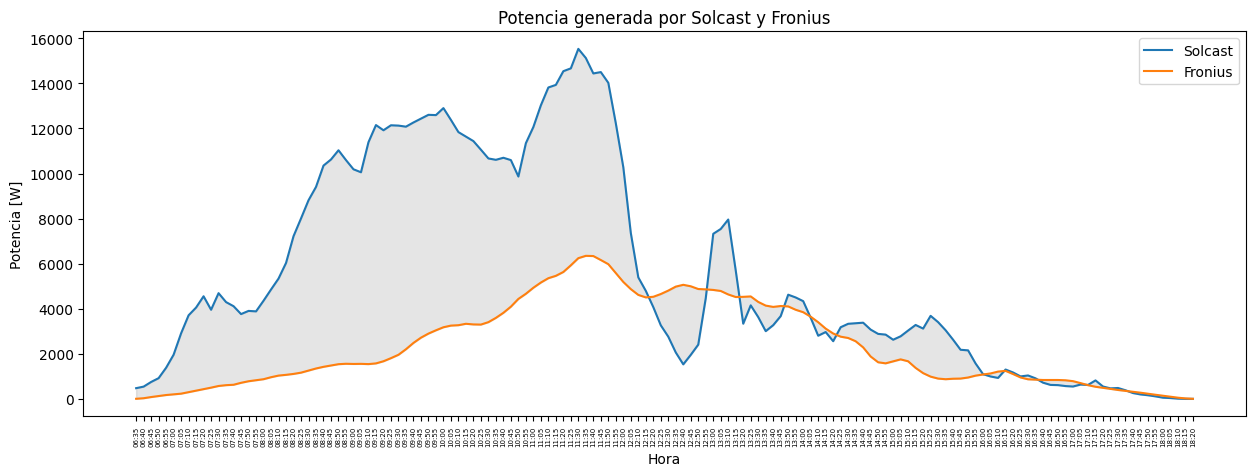

In [18]:
# suma de la potencia generada solcast
energia = df['P_cloud_opacity']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_cloud_opacity'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_cloud_opacity'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()

## Potencia calulada teniendo en cuenta GHI, nubosidad y temperatura del aire


# temperatura del aire

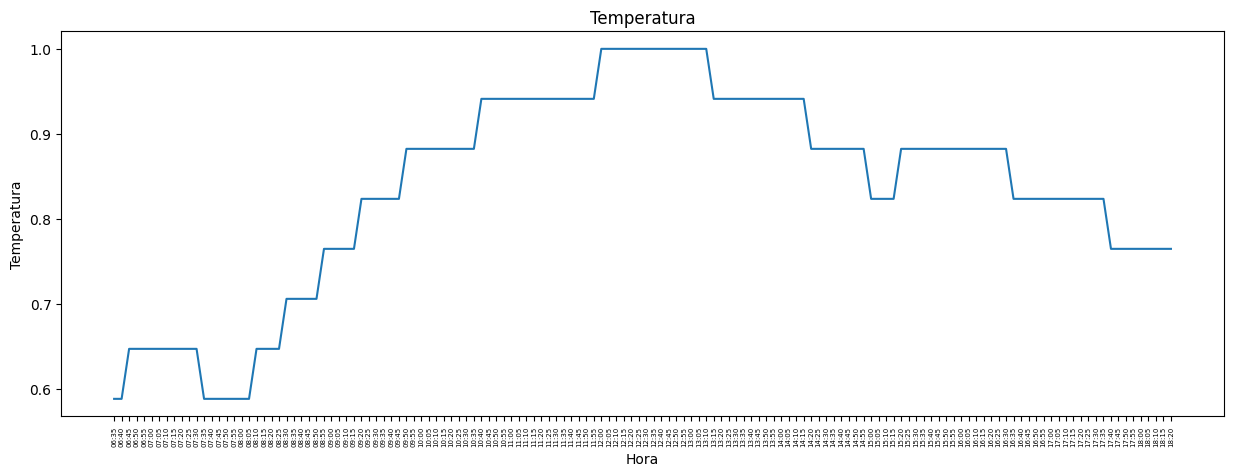

In [19]:
# normalizar 'air_temp' de 0 a 1  en donde 1 es el valor más alto
df['air_temp'] = df['air_temp'] / df['air_temp'].max()

# graficar la temperatura
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['air_temp'])
plt.title('Temperatura')
plt.xlabel('Hora')
plt.ylabel('Temperatura')
plt.xticks(rotation=90, size=5)
plt.show()

Energía calculada solacast [kWh] = 29.423555976811265
Energía calculada fronius [kWh] = 27.775229999999997
Error porcentual: 5.934517830495984 %


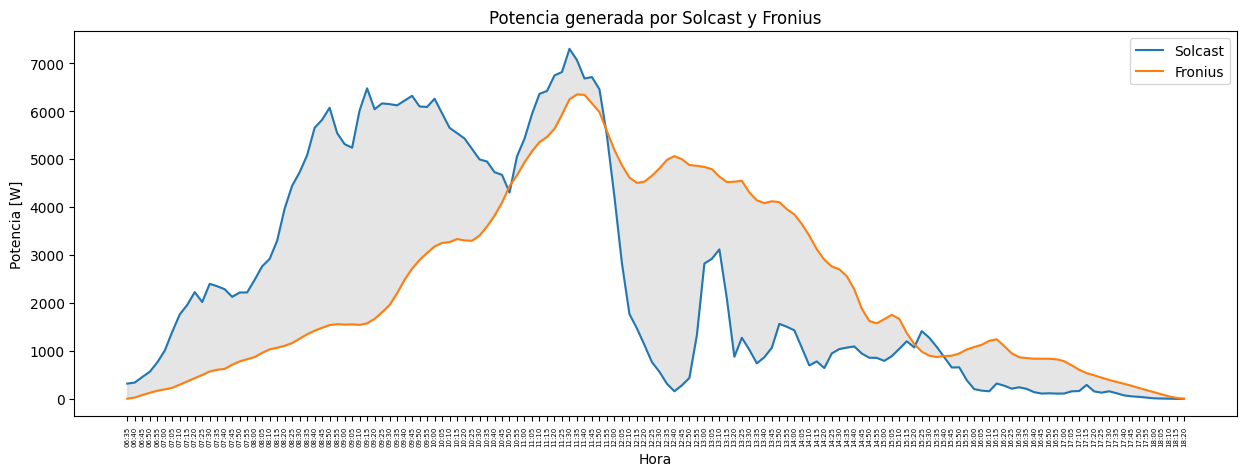

In [30]:
df['P_cloud_opacity_temp'] = df['GHI'] * efficiency *  area * catidad_pv * (1 - 0.9*df['cloud_opacity']) * (1 - 0.5*df['air_temp'])
# suma de la potencia generada solcast
energia = df['P_cloud_opacity_temp']*(5/60)
print("Energía calculada solacast [kWh] =",energia.sum()/1000)

# suma de la potencia generada fronius
energia_fronius = df['Potencia']*(5/60)
print("Energía calculada fronius [kWh] =",energia_fronius.sum()/1000)

# error porcentual
error = abs(  energia.sum() - energia_fronius.sum()) / energia_fronius.sum() * 100
print('Error porcentual:', error, '%')

# graficar la energía generada por solcast y fronius
plt.figure(figsize=(15, 5))
plt.plot(df['Time'], df['P_cloud_opacity_temp'], label='Solcast')
plt.plot(df['Time'], df['Potencia'], label='Fronius')
# grafico area bajo la curva
plt.fill_between(df['Time'], df['P_cloud_opacity_temp'], df['Potencia'], color='gray', alpha=0.2)
plt.title('Potencia generada por Solcast y Fronius')
plt.xlabel('Hora')
plt.ylabel('Potencia [W]')
plt.legend()
plt.xticks(rotation=90, size=5)
plt.show()